### Import Libraries and Load Drive

In [1]:
import pandas as pd
import itertools
import numpy as np
from sklearn import pipeline,ensemble,preprocessing,feature_extraction,metrics
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import pickle
from joblib import dump, load
import os

from sklearn.model_selection import StratifiedShuffleSplit


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Set your project path 
project_path =  '/content/drive/My Drive/Colab Notebooks/DataSets'

# set the google drive directory path to read and save all files there
os.chdir(project_path)

### Read File Stored After EDA

In [0]:
# df = pd.read_excel('EDA_Processed_Cleaned_TicketData.xlsx')
df = pd.read_excel('EDA_Processed_Cleaned_TicketData_OverSample.xlsx')
dfModelBuilding = df[['LemmaString','NewAssignmentGroup']]

In [5]:
dfModelBuilding['NewAssignmentGroup'].value_counts()

GRP_0     3266
GRP_12    1440
GRP_2     1440
GRP_19    1170
GRP_3     1146
GRP_9     1038
GRP_24    1014
GRP_13     966
GRP_8      911
GRP_10     840
GRP_98     799
GRP_14     791
GRP_25     763
GRP_5      728
GRP_99     659
Name: NewAssignmentGroup, dtype: int64

### Define Groups For L12 and L3

In [0]:
Grp1 = ['GRP_0', 'GRP_8', 'GRP_2', 'GRP_12', 'GRP_19',  'GRP_3', 'GRP_9', 'GRP_24']
Grp2 = ['GRP_10', 'GRP_13', 'GRP_14','GRP_5', 'GRP_25','GRP_98','GRP_99']

In [0]:
def SetGrp(text):
    if text in Grp1:
        return 0
    if text in Grp2:
        return 1

In [8]:
dfModelBuilding['Level1Grp'] = dfModelBuilding['NewAssignmentGroup'].apply(lambda x : SetGrp(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
dfModelBuilding.head()

,LemmaString,NewAssignmentGroup,Level1Grp
0,login issue verify user detail employee manage...,GRP_0,0
1,outlook team meeting skype not appear calendar...,GRP_0,0
2,ca not log vpn can not,GRP_0,0
3,unable access hr tool,GRP_0,0
4,unable log engineer tool skype,GRP_0,0


In [10]:
dfModelBuilding.groupby('Level1Grp').size().sort_values(ascending=False)

Level1Grp
0    11425
1     5546
dtype: int64

## Model Execution

### Score Functions

In [0]:
# def print_scores(y_test,y_pred,y_pred_prob):
def print_scores(y_test,y_pred):
    print("Accuracy score: \n", accuracy_score(y_test,y_pred))
    print('Test-set confusion matrix:\n', confusion_matrix(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, fmt='g')
    print("Classification report:" "\n", classification_report(y_test,y_pred))
    # print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob[:,1])))

In [0]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)

### Random Forest - Create Pipeline (**Level-1 Groups**)

In [0]:
# the below pipeline is for the level1 group identification and another pipeline to second level

clf=pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
        ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500,verbose=1,n_jobs=-1))
    ])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dfModelBuilding['LemmaString'], dfModelBuilding['Level1Grp'], test_size=0.2)

In [15]:
X_test

2049                    unable connect vpn update password
10805    security incident repeat outbound connection t...
12010    account activation morning reactivate colleagu...
2911                       job fail scheduler monitor tool
9007              monitor will not display video no signal
                               ...                        
8498     qualys scan require server completion hostname...
5006     sysetem remote access dear sir system ca not awyw
16529         hostname rfcserver exe process count service
2942     uacyltoe hxgaycze email neerthyu agrtywal not ...
16940    error customer morning include datum dana manu...
Name: LemmaString, Length: 3395, dtype: object

In [16]:
model = clf.fit(X_train,y_train)
#clf.fit(dfModelBuilding['LemmaString'],dfModelBuilding['Level1Grp'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.6s finished


In [0]:
rf_model = model.steps[1][1]
import pickle
with open('model_RandomForestFirstLevel.pickle', 'wb') as f:
    pickle.dump(rf_model, f)

In [0]:
with open('model_RandomForestFirstLevel.pickle', 'rb') as f:
    firstlevel_model = pickle.load(f, encoding='iso-8859-1')

In [21]:
from sklearn.externals import joblib
joblib.dump(model, 'model_RandomForestFirstLevel.model')

['model_RandomForestFirstLevel.model']

In [0]:
fittedModel = joblib.load('model_RandomForestFirstLevel.model')

In [0]:
labels = ['L12','L3']

In [24]:
X_new = ['need vpn access employee laptop emzlw']
pred = fittedModel.predict(X_new) 
level = labels[pred[0]]
level

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


'L12'

In [0]:
texts = 'skype business extend access external partner contractor she arrange conference call party work critical payroll project germany involve significant vendor contact her permission should set same'

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tk = Tokenizer()
tk.fit_on_texts(texts)
index_list = tk.texts_to_sequences(texts)
x_train = pad_sequences(index_list, maxlen=8794, padding='post', truncating='post')

In [27]:
firstlevel_model.warm_start

False

In [28]:
#y_pred=clf.predict(dfModelBuilding['LemmaString'])
#y_pred_prob = clf.predict_proba(dfModelBuilding['LemmaString'])
#print(metrics.confusion_matrix(dfModelBuilding['Level1Grp'],y_pred))
#print(metrics.accuracy_score(dfModelBuilding['Level1Grp'],y_pred))

y_pred=clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(metrics.confusion_matrix(y_test,y_pred))
print(metrics.accuracy_score(y_test,y_pred))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s


[[2229   21]
 [ 162  983]]
0.9460972017673048


[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.6s finished


In [29]:
y_pred_prob

array([[0.998, 0.002],
       [1.   , 0.   ],
       [0.992, 0.008],
       ...,
       [0.014, 0.986],
       [0.648, 0.352],
       [0.   , 1.   ]])

Accuracy score: 
 0.9460972017673048
Test-set confusion matrix:
 [[2229   21]
 [ 162  983]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      2250
           1       0.98      0.86      0.91      1145

    accuracy                           0.95      3395
   macro avg       0.96      0.92      0.94      3395
weighted avg       0.95      0.95      0.95      3395



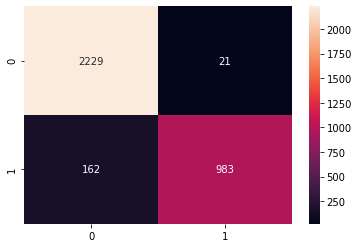

In [30]:
#print_scores(dfModelBuilding['Level1Grp'],y_pred)
print_scores(y_test,y_pred)

####Analysis
- For Class 0, higher recall indicates low false negative rate.
- For Class 1, higher precision indicates low false positive rate.

In [0]:
# cm = confusion_matrix(dfModelBuilding['Level1Grp'],y_pred)
# sns.heatmap(cm, annot=True, fmt='g')
# print("Classification report:" "\n", classification_report(dfModelBuilding['Level1Grp'],y_pred))

In [0]:
clf2=pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
        ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500,verbose=1,n_jobs=-1))
    ])

In [0]:
clf3=pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
        ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500,verbose=1,n_jobs=-1))
    ])

In [0]:
partDfZero = dfModelBuilding.loc[dfModelBuilding['Level1Grp'] == 0]
partDfOne = dfModelBuilding.loc[dfModelBuilding['Level1Grp'] == 1]

In [35]:
le1 = LabelEncoder()
le2 = LabelEncoder()

partDfZero['AssignmentGroup'] = le1.fit_transform(partDfZero['NewAssignmentGroup'])
partDfOne['AssignmentGroup'] = le2.fit_transform(partDfOne['NewAssignmentGroup'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
X_train, X_test, y_train, y_test = train_test_split(partDfZero['LemmaString'], partDfZero['AssignmentGroup'], test_size=0.2)

In [37]:
#clf2.fit(partDfZero['LemmaString'], partDfZero['AssignmentGroup'])
#y2_pred = clf2.predict(partDfZero['LemmaString'])
#y2_pred_prob = clf2.predict_proba(partDfZero['LemmaString'])
#print('Accuracy of partdf zero is ===>>')
#print(metrics.accuracy_score(partDfZero['AssignmentGroup'],y2_pred))

model0 = clf2.fit(X_train,y_train)
y2_pred = clf2.predict(X_test)
y2_pred_prob = clf2.predict_proba(X_test)

print('Accuracy of partdf zero is ===>>')
print(metrics.accuracy_score(y_test,y2_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s


Accuracy of partdf zero is ===>>
0.9894967177242888


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finished


In [38]:
joblib.dump(model0, 'model_RandomForestL12.model')

['model_RandomForestL12.model']

Accuracy score: 
 0.9894967177242888
Test-set confusion matrix:
 [[649   3   2   2   1   1   0   1]
 [  0 282   0   0   0   0   0   0]
 [  0   0 256   0   0   0   0   0]
 [  0   0   0 294   0   0   0   0]
 [  0   0   0   0 196   0   0   0]
 [  0   0   0   0   0 221   0   0]
 [  5   9   0   0   0   0 173   0]
 [  0   0   0   0   0   0   0 190]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       659
           1       0.96      1.00      0.98       282
           2       0.99      1.00      1.00       256
           3       0.99      1.00      1.00       294
           4       0.99      1.00      1.00       196
           5       1.00      1.00      1.00       221
           6       1.00      0.93      0.96       187
           7       0.99      1.00      1.00       190

    accuracy                           0.99      2285
   macro avg       0.99      0.99      0.99      2285
weighted avg       0.99      0.99 

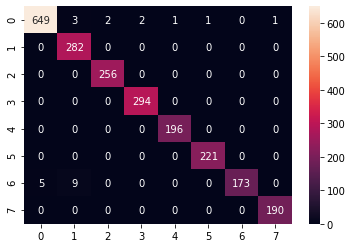

In [39]:
#print_scores(partDfZero['AssignmentGroup'],y2_pred)
## ,y2_pred_prob)
#print("ROC_AUC_Score: ", multiclass_roc_auc_score(partDfZero['AssignmentGroup'],y2_pred))

print_scores(y_test,y2_pred)
# ,y2_pred_prob)
print("ROC_AUC_Score: ", multiclass_roc_auc_score(y_test,y2_pred))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(partDfOne['LemmaString'], partDfOne['AssignmentGroup'], test_size=0.2)

In [41]:
#clf3.fit(partDfOne['LemmaString'], partDfOne['AssignmentGroup'])
#y3_pred = clf3.predict(partDfOne['LemmaString'])
#y3_pred_prob = clf2.predict_proba(partDfOne['LemmaString'])

#print('Accuracy of partdf One is ===>>')
#print(metrics.accuracy_score(partDfOne['AssignmentGroup'],y3_pred))

model1 = clf3.fit(X_train, y_train)
y3_pred = clf3.predict(X_test)
y3_pred_prob = clf2.predict_proba(X_test)

print('Accuracy of partdf One is ===>>')
print(metrics.accuracy_score(y_test,y3_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finis

Accuracy of partdf One is ===>>
0.9144144144144144


In [42]:
joblib.dump(model1, 'model_RandomForestL3.model')

['model_RandomForestL3.model']

Accuracy score: 
 0.9144144144144144
Test-set confusion matrix:
 [[170   0   0   0   0   0   0]
 [  0 183   0   0   0   0   0]
 [  0   0 145   0   0   0   0]
 [  0   0   0 172   0   0   0]
 [  0   0   0   0 141   0   0]
 [  1   8   0   6   2 126  20]
 [  3   1   6  12   3  33  78]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       170
           1       0.95      1.00      0.98       183
           2       0.96      1.00      0.98       145
           3       0.91      1.00      0.95       172
           4       0.97      1.00      0.98       141
           5       0.79      0.77      0.78       163
           6       0.80      0.57      0.67       136

    accuracy                           0.91      1110
   macro avg       0.91      0.91      0.90      1110
weighted avg       0.91      0.91      0.91      1110

ROC_AUC_Score:  0.9461873845113413


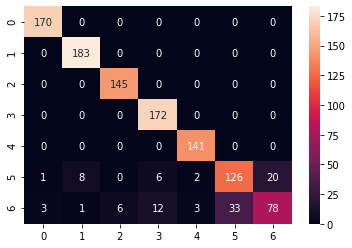

In [43]:
#print_scores(partDfOne['AssignmentGroup'],y3_pred)
## ,y3_pred_prob)
#print("ROC_AUC_Score: ", multiclass_roc_auc_score(partDfOne['AssignmentGroup'],y3_pred))

print_scores(y_test,y3_pred)
# ,y2_pred_prob)
print("ROC_AUC_Score: ", multiclass_roc_auc_score(y_test,y3_pred))

In [0]:
# dump(clf,'clf.joblib')
# dump(clf2,'clf2.joblib')
# dump(clf3,'clf3.joblib')

### Predict New Incoming Data

In [0]:
# df = pd.read_excel('EDACompletedTicketData.xlsx')
df = pd.read_excel('TestDataToPredict.xlsx')

In [0]:
#doing this on test dataa to ensure what groups we have considered into different 2 major groups
# df['Level1Grp'] = df['AssignmentGroup'].apply(lambda x : SetGrp(x))

In [47]:
print(df.shape)
df.head()

(15, 2)


,LemmaString,NewAssignmentGroup
0,telephony software issue,GRP_0
1,robot hostname inactive,GRP_8
2,display fix telephone system area defective nu...,GRP_99
3,job hr payroll fail scheduler monitor tool,GRP_10
4,telephony software issue bad quality sound hor...,GRP_98


In [48]:
y1_Testpred = clf.predict(df['LemmaString'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


In [49]:
print("ROC_AUC_Score: ", multiclass_roc_auc_score(df['NewAssignmentGroup'],y1_Testpred))

ROC_AUC_Score:  0.5


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [50]:
df['y1_pred'] = 'y1_pred'
df['y2_pred'] = 'y2_pred'
df['y3_pred'] = 'y3_pred'
df['FinalPredictions'] = 'UNK9999'
df.head()

,LemmaString,NewAssignmentGroup,y1_pred,y2_pred,y3_pred,FinalPredictions
0,telephony software issue,GRP_0,y1_pred,y2_pred,y3_pred,UNK9999
1,robot hostname inactive,GRP_8,y1_pred,y2_pred,y3_pred,UNK9999
2,display fix telephone system area defective nu...,GRP_99,y1_pred,y2_pred,y3_pred,UNK9999
3,job hr payroll fail scheduler monitor tool,GRP_10,y1_pred,y2_pred,y3_pred,UNK9999
4,telephony software issue bad quality sound hor...,GRP_98,y1_pred,y2_pred,y3_pred,UNK9999


In [51]:
df['y1_pred'] = pd.Series(y1_Testpred)
df.head()

,LemmaString,NewAssignmentGroup,y1_pred,y2_pred,y3_pred,FinalPredictions
0,telephony software issue,GRP_0,0,y2_pred,y3_pred,UNK9999
1,robot hostname inactive,GRP_8,0,y2_pred,y3_pred,UNK9999
2,display fix telephone system area defective nu...,GRP_99,1,y2_pred,y3_pred,UNK9999
3,job hr payroll fail scheduler monitor tool,GRP_10,1,y2_pred,y3_pred,UNK9999
4,telephony software issue bad quality sound hor...,GRP_98,1,y2_pred,y3_pred,UNK9999


In [0]:
partZero = df[df['y1_pred'] == 0]
partOne = df[df['y1_pred'] == 1]

In [53]:
y2_Testpred = clf2.predict(partZero['LemmaString'])
y3_Testpred = clf3.predict(partOne['LemmaString'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


In [54]:
partZero.head()

,LemmaString,NewAssignmentGroup,y1_pred,y2_pred,y3_pred,FinalPredictions
0,telephony software issue,GRP_0,0,y2_pred,y3_pred,UNK9999
1,robot hostname inactive,GRP_8,0,y2_pred,y3_pred,UNK9999
5,account lock,GRP_0,0,y2_pred,y3_pred,UNK9999
7,erp sid access reason error state account not ...,GRP_2,0,y2_pred,y3_pred,UNK9999
10,ROBOT SYSTEM IS INACTIVE,GRP_8,0,y2_pred,y3_pred,UNK9999


In [55]:
partOne.head()

,LemmaString,NewAssignmentGroup,y1_pred,y2_pred,y3_pred,FinalPredictions
2,display fix telephone system area defective nu...,GRP_99,1,y2_pred,y3_pred,UNK9999
3,job hr payroll fail scheduler monitor tool,GRP_10,1,y2_pred,y3_pred,UNK9999
4,telephony software issue bad quality sound hor...,GRP_98,1,y2_pred,y3_pred,UNK9999
6,hostname application plm dsc file node unreach...,GRP_14,1,y2_pred,y3_pred,UNK9999
8,job dir fail scheduler monitor tool,GRP_5,1,y2_pred,y3_pred,UNK9999


In [56]:
print("ROC_AUC_Score: ", multiclass_roc_auc_score(partZero['NewAssignmentGroup'],y2_Testpred))

ROC_AUC_Score:  0.5


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [57]:
print("ROC_AUC_Score: ", multiclass_roc_auc_score(partOne['NewAssignmentGroup'],y3_Testpred))

ROC_AUC_Score:  0.5


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
countZero =0
for i in partZero.index:
    x = y2_Testpred[countZero]
    df.at[i, 'y2_pred'] = x
    df.at[i, 'FinalPredictions'] = Grp1[x]
    countZero +=1

In [0]:
countOne =0
for i in partOne.index:
    x = y3_Testpred[countOne]
    df.at[i, 'y3_pred'] = x
    df.at[i, 'FinalPredictions'] = Grp2[x]
    countOne +=1 

In [60]:
df.head(10)

,LemmaString,NewAssignmentGroup,y1_pred,y2_pred,y3_pred,FinalPredictions
0,telephony software issue,GRP_0,0,0,y3_pred,GRP_0
1,robot hostname inactive,GRP_8,0,6,y3_pred,GRP_9
2,display fix telephone system area defective nu...,GRP_99,1,y2_pred,5,GRP_98
3,job hr payroll fail scheduler monitor tool,GRP_10,1,y2_pred,0,GRP_10
4,telephony software issue bad quality sound hor...,GRP_98,1,y2_pred,5,GRP_98
5,account lock,GRP_0,0,0,y3_pred,GRP_0
6,hostname application plm dsc file node unreach...,GRP_14,1,y2_pred,2,GRP_14
7,erp sid access reason error state account not ...,GRP_2,0,3,y3_pred,GRP_12
8,job dir fail scheduler monitor tool,GRP_5,1,y2_pred,4,GRP_25
9,tool batch management pdv system absolutely ba...,GRP_25,1,y2_pred,3,GRP_5


In [0]:
# df.to_excel('FinalPredictions.xlsx',index=False)

### Using Shuffle Split

In [0]:
vectorizer = feature_extraction.text.TfidfVectorizer()
train_vectors = vectorizer.fit_transform(dfModelBuilding.LemmaString)

In [0]:
clf_ShuffleSplit = pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
        ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500,verbose=1,n_jobs=-1))
    ])
clf_ShuffleSplit2 = pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
        ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500,verbose=1,n_jobs=-1))
    ])
clf_ShuffleSplit3 = pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
        ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500,verbose=1,n_jobs=-1))
    ])

In [0]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=11)

In [65]:
for train_index, test_index in sss.split(train_vectors, dfModelBuilding['Level1Grp']):
  X_train, X_test = dfModelBuilding['LemmaString'][train_index], dfModelBuilding['LemmaString'][test_index]
  y_train, y_test = dfModelBuilding['Level1Grp'][train_index], dfModelBuilding['Level1Grp'][test_index]
  clf_ShuffleSplit.fit(X_train,y_train)
  y_pred_ShuffleSplit=clf_ShuffleSplit.predict(X_test)
  print(metrics.confusion_matrix(y_test,y_pred_ShuffleSplit))
  print(metrics.accuracy_score(y_test,y_pred_ShuffleSplit))
  print("ROC_AUC_Score: ", roc_auc_score(y_test,y_pred_ShuffleSplit))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.9s finished


[[3402   26]
 [ 235 1429]]
0.9487431264728987
ROC_AUC_Score:  0.9255947205143163


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.9s finished


[[3393   35]
 [ 246 1418]]
0.944815396700707
ROC_AUC_Score:  0.9209767132663137


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.9s finished


[[3388   40]
 [ 233 1431]]
0.9463864886095836
ROC_AUC_Score:  0.9241536750516112


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.9s finished


[[3393   35]
 [ 270 1394]]
0.940102120974077
ROC_AUC_Score:  0.9137651748047751


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s


[[3392   36]
 [ 276 1388]]
0.9387274155538099
ROC_AUC_Score:  0.9118164325464501


[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.8s finished


In [0]:
train_vectors_L12 = vectorizer.fit_transform(partDfZero['LemmaString'])

In [67]:
for train_index, test_index in sss.split(train_vectors_L12, partDfZero['AssignmentGroup']):
  train_lemma = partDfZero['LemmaString'][train_index][~partDfZero['LemmaString'][train_index].isna()]
  test_lemma = partDfZero['LemmaString'][test_index][~partDfZero['LemmaString'][test_index].isna()]
  train_group = partDfZero['AssignmentGroup'][train_index][~partDfZero['AssignmentGroup'][train_index].isna()]
  test_group = partDfZero['AssignmentGroup'][test_index][~partDfZero['AssignmentGroup'][test_index].isna()]

  X_train, X_test = train_lemma, test_lemma
  y_train, y_test = train_group, test_group
  clf_ShuffleSplit2.fit(X_train,y_train)
  y2_pred_ShuffleSplit2=clf_ShuffleSplit2.predict(X_test)
  print(metrics.confusion_matrix(y_test,y2_pred_ShuffleSplit2))
  print(metrics.accuracy_score(y_test,y2_pred_ShuffleSplit2))
  print("ROC_AUC_Score: ", multiclass_roc_auc_score(y_test,y2_pred_ShuffleSplit2))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500

[[959  12   5   6   8   4   0   2]
 [  0 296   0   0   0   0   0   0]
 [  0   0 254   0   0   0   0   0]
 [  0   0   0 307   0   0   0   0]
 [  0   0   0   0 212   0   0   0]
 [  0   0   0   0   0 254   0   0]
 [  7   9   0   0   0   0 247   1]
 [  0   0   0   0   0   0   0 230]]
0.9808034127266264
ROC_AUC_Score:  0.9922570789627435


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finished
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-

[[965   9   7   7   8   3   1   0]
 [  0 308   0   0   0   0   0   0]
 [  4   0 234   0   0   0   0   0]
 [  0   0   0 308   0   0   0   0]
 [  5   0   4   0 214   0   0   0]
 [  0   0   0   0   0 250   0   0]
 [  5   7   0   0   0   0 281   0]
 [  0   0   0   0   0   0   0 204]]
0.9787535410764873
ROC_AUC_Score:  0.9900732470525941


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finished
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-

[[971   8   7   1   4   6   0   0]
 [  0 296   0   0   0   0   0   0]
 [  4   0 260   0   0   0   0   0]
 [ 12   0   0 324   0   0   0   0]
 [  0   0   0   0 212   0   0   0]
 [  0   0   0   0   0 239   0   0]
 [  9   7   0   0   0   0 262   3]
 [  0   0   0   0   0   0   0 225]]
0.9785964912280701
ROC_AUC_Score:  0.9892508592200296


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finished
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-

[[968  11   8   5   6   5   0   0]
 [  4 310   0   0   0   0   0   0]
 [ 12   0 240   0   0   0   0   0]
 [  4   0   0 334   0   0   0   0]
 [  0   0   0   0 211   0   0   0]
 [  5   0   0   0   0 258   0   0]
 [  6  13   0   0   0   0 266   1]
 [  0   0   0   0   0   0   0 207]]
0.9721642310368824
ROC_AUC_Score:  0.9855288479727564


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s


[[992   9   6   5   2   8   0   1]
 [  0 284   0   0   0   0   0   0]
 [  4   0 228   0   0   0   0   0]
 [  0   0   0 353   0   0   0   0]
 [  0   4   0   0 220   0   0   0]
 [  9   0   0   0   4 222   0   0]
 [  5   7   0   0   0   0 249   0]
 [  0   0   0   0   0   0   0 202]]
0.9772565742714996
ROC_AUC_Score:  0.9878243746771815


[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finished


In [0]:
train_vectors_L3 = vectorizer.fit_transform(partDfOne['LemmaString'])

In [69]:
for train_index, test_index in sss.split(train_vectors_L3, partDfOne['AssignmentGroup']):
  train_lemma = partDfOne['LemmaString'][train_index][~partDfOne['LemmaString'][train_index].isna()]
  test_lemma = partDfOne['LemmaString'][test_index][~partDfOne['LemmaString'][test_index].isna()]
  train_group = partDfOne['AssignmentGroup'][train_index][~partDfOne['AssignmentGroup'][train_index].isna()]
  test_group = partDfOne['AssignmentGroup'][test_index][~partDfOne['AssignmentGroup'][test_index].isna()]

  X_train, X_test = train_lemma, test_lemma
  y_train, y_test = train_group, test_group
  clf_ShuffleSplit3.fit(X_train,y_train)
  y3_pred_ShuffleSplit=clf_ShuffleSplit3.predict(X_test)
  print(metrics.confusion_matrix(y_test,y3_pred_ShuffleSplit))
  print(metrics.accuracy_score(y_test,y3_pred_ShuffleSplit))
  print("ROC_AUC_Score: ", multiclass_roc_auc_score(y_test,y3_pred_ShuffleSplit))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500

[[ 12   2   0   0   0  10  13]
 [  0  12   0   0   0  12   7]
 [  0   0  12   0   0   3   4]
 [  0   0   0  15   0   6   3]
 [  0   0   0   0  13   2   3]
 [  0   0   0   1   0 140  22]
 [  0   0   2   2   1  65  86]]
0.6473214285714286
ROC_AUC_Score:  0.7542570687988143


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500

[[ 17   1   0   0   0   6   6]
 [  0  13   0   0   0  10   8]
 [  0   0  10   0   0   5  14]
 [  0   0   0  22   0   5   5]
 [  0   0   0   0  19   0   1]
 [  0   2   2   0   2 143  23]
 [  1   0   0   4   4  49  89]]
0.6789587852494577
ROC_AUC_Score:  0.7805204552146539


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500

[[ 15   2   0   0   0   7  10]
 [  1  11   1   1   0  13  10]
 [  0   0   6   1   0   6  11]
 [  0   0   0  12   0   5   7]
 [  0   0   0   0  19   0   7]
 [  0   0   1   1   1 147  25]
 [  0   0   0   5   2  39  78]]
0.6486486486486487
ROC_AUC_Score:  0.726497330127539


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500

[[ 16   3   0   0   0   4   6]
 [  0  12   0   0   0  16  11]
 [  0   0   6   1   0  11  11]
 [  0   1   0  18   0   3   7]
 [  0   0   0   0  19   1   1]
 [  0   2   0   0   0 148  38]
 [  0   0   0   7   3  46  85]]
0.6386554621848739
ROC_AUC_Score:  0.7458192486747749


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s


[[ 15   3   0   0   0   3  10]
 [  0  14   0   0   0  13   8]
 [  0   0   7   2   0   4   9]
 [  0   0   0  16   0   9   9]
 [  0   0   0   0  15   0   2]
 [  0   1   0   0   1 156  40]
 [  1   1   0   4   0  33  91]]
0.6723768736616702
ROC_AUC_Score:  0.753642056125141


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


### Predict On Basis of Shuffle Split

In [70]:
dfShuffle = pd.read_excel('TestDataToPredict.xlsx')
dfShuffle.head(10)

,LemmaString,NewAssignmentGroup
0,telephony software issue,GRP_0
1,robot hostname inactive,GRP_8
2,display fix telephone system area defective nu...,GRP_99
3,job hr payroll fail scheduler monitor tool,GRP_10
4,telephony software issue bad quality sound hor...,GRP_98
5,account lock,GRP_0
6,hostname application plm dsc file node unreach...,GRP_14
7,erp sid access reason error state account not ...,GRP_2
8,job dir fail scheduler monitor tool,GRP_5
9,tool batch management pdv system absolutely ba...,GRP_25


In [0]:
train_vectors = vectorizer.fit_transform(dfShuffle.LemmaString)

In [72]:
y1_TestPred_shuffle = clf_ShuffleSplit.predict(dfShuffle['LemmaString'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


In [73]:
print("ROC_AUC_Score: ", multiclass_roc_auc_score(dfShuffle['NewAssignmentGroup'],y1_TestPred_shuffle))

ROC_AUC_Score:  0.5


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [74]:
dfShuffle['y1_pred'] = 'y1_pred'
dfShuffle['y2_pred'] = 'y2_pred'
dfShuffle['y3_pred'] = 'y3_pred'
dfShuffle['FinalPredictions'] = 'UNK9999'
dfShuffle.head()

,LemmaString,NewAssignmentGroup,y1_pred,y2_pred,y3_pred,FinalPredictions
0,telephony software issue,GRP_0,y1_pred,y2_pred,y3_pred,UNK9999
1,robot hostname inactive,GRP_8,y1_pred,y2_pred,y3_pred,UNK9999
2,display fix telephone system area defective nu...,GRP_99,y1_pred,y2_pred,y3_pred,UNK9999
3,job hr payroll fail scheduler monitor tool,GRP_10,y1_pred,y2_pred,y3_pred,UNK9999
4,telephony software issue bad quality sound hor...,GRP_98,y1_pred,y2_pred,y3_pred,UNK9999


In [75]:
dfShuffle['y1_pred'] = pd.Series(y1_TestPred_shuffle)
dfShuffle.head()

,LemmaString,NewAssignmentGroup,y1_pred,y2_pred,y3_pred,FinalPredictions
0,telephony software issue,GRP_0,0,y2_pred,y3_pred,UNK9999
1,robot hostname inactive,GRP_8,0,y2_pred,y3_pred,UNK9999
2,display fix telephone system area defective nu...,GRP_99,0,y2_pred,y3_pred,UNK9999
3,job hr payroll fail scheduler monitor tool,GRP_10,1,y2_pred,y3_pred,UNK9999
4,telephony software issue bad quality sound hor...,GRP_98,1,y2_pred,y3_pred,UNK9999


In [0]:
partZero = dfShuffle[dfShuffle['y1_pred'] == 0]
partOne = dfShuffle[dfShuffle['y1_pred'] == 1]

In [77]:
partZero.head(10)

,LemmaString,NewAssignmentGroup,y1_pred,y2_pred,y3_pred,FinalPredictions
0,telephony software issue,GRP_0,0,y2_pred,y3_pred,UNK9999
1,robot hostname inactive,GRP_8,0,y2_pred,y3_pred,UNK9999
2,display fix telephone system area defective nu...,GRP_99,0,y2_pred,y3_pred,UNK9999
5,account lock,GRP_0,0,y2_pred,y3_pred,UNK9999
7,erp sid access reason error state account not ...,GRP_2,0,y2_pred,y3_pred,UNK9999
10,ROBOT SYSTEM IS INACTIVE,GRP_8,0,y2_pred,y3_pred,UNK9999
11,TELEPHONE SYSTEM DISPLAY IS NOT WORKING,GRP_99,0,y2_pred,y3_pred,UNK9999
12,POOR QUALITY OF TELEPHONY SOFTWARE,GRP_98,0,y2_pred,y3_pred,UNK9999
13,FACING ERP ACCESS ISSUE,GRP_2,0,y2_pred,y3_pred,UNK9999


In [78]:
y2_TestPred_Shuffle = clf_ShuffleSplit2.predict(partZero['LemmaString'])
y3_TestPred_Shuffle = clf_ShuffleSplit3.predict(partOne['LemmaString'])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score: 
 0.5555555555555556
Test-set confusion matrix:
 [[5 1 1 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.56         9
   macro avg       0.20      0.11      0.14         9
weighted avg       1.00      0.56      0.71         9



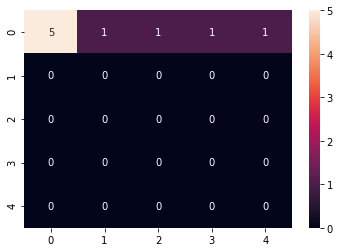

In [79]:
print_scores(partZero['y1_pred'],y2_TestPred_Shuffle.astype(int))

In [80]:
print("ROC_AUC_Score: ", multiclass_roc_auc_score(partZero['NewAssignmentGroup'],y2_TestPred_Shuffle.astype(int)))

ROC_AUC_Score:  0.5


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score: 
 0.0
Test-set confusion matrix:
 [[0 0 0 0 0]
 [1 0 1 1 3]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       6.0
           2       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0

    accuracy                           0.00       6.0
   macro avg       0.00      0.00      0.00       6.0
weighted avg       0.00      0.00      0.00       6.0



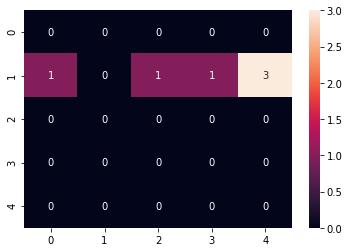

In [81]:
print_scores(partOne['y1_pred'],y3_TestPred_Shuffle.astype(int))

In [82]:
print("ROC_AUC_Score: ", multiclass_roc_auc_score(partOne['NewAssignmentGroup'],y3_TestPred_Shuffle.astype(int)))

ROC_AUC_Score:  0.5


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
